#  El Problema

Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo es aplicar algortimos de aprendizaje supervisado para obtener el mejor score posible al predecir mediante el data set de train los resultados. La validación se hará cargando los datos en la web del concurso. 
Además se buscará mejorar los resultados variando los algortimos, los datos y las features, y los parámetros de estos.   

*Se ha tenido un problema que se desconoce a ciencia cierta de donde viene, pero a pesar de establecer la seed en los algoritmos los resultados varian ligeramente de una ejecucióna  otra haciendo que variaciones de -0.3 del MAE se conviertan en +0.2 haciendo que la descripción y comentarios pueda llegar a no ajustarse. Se asume este hecho y su repercusión, a modo de garantia se comparte un screen shot de los resultados del concurso.   

Para la ejecución del cuaderno se sugiere tener todos los archivos en una carpeta de drive, al ejecutar este cuaderno se le pedira el path relativo desde la carpeta de MyDrive y se introducirá precedido de /. Si estan en la carpeta de Manuel; **/Manuel** será lo que se deba introducir.   

En caso de fallar la carga se pueden subir uno por uno, pero dado el número es un poco latoso. 

Se han programado unos algoritmos de cross validation para buscar parámetros optimos en Random Forest, se sugiere NO pulsar 1 ya que tardan del orden de las dos horas. Tanto 0 como cualquier tecla cargan el mismo modelo. 


# Setting Preliminares

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

In [2]:
# Imports generales
import pandas as pd
import io
from google.colab import files

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

# Carga de Datos

In [3]:
path=input('Introduce el path relativo donde vas a abrir los archivos. Ejemplo /miCarpeta/machineLearning o /miCarpeta ')
if path == None:
  path=''

Introduce el path relativo donde vas a abrir los archivos. Ejemplo /miCarpeta/machineLearning o /miCarpeta /BelloLeguaManuel


In [4]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv) y subir dengue_features_test.csv. Si lo tiene en el directorio de drive puede cancelar esta acción
try:
  train_feat = upload_files()#dengue_features_train.csv
  train_label=upload_files() #dengue_labels_train.csv
  test=upload_files()#dengue_features_test.csv
  df_sinNorm=upload_files()#datos_finales_sinnormalizar.csv
  testsn=upload_files()#test_sinnormalizar.csv
except:
  pass

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [5]:
from google.colab import drive

try:
  drive.mount('/content/drive',force_remount=True)
  train_feat=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_features_train.csv')
  train_label=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_labels_train.csv')
  test=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_features_test.csv')
  df_sinNorm=pd.read_csv('/content/drive/MyDrive'+path+'/datos_finales_sinnormalizar.csv')
  testsn=pd.read_csv('/content/drive/MyDrive'+path+'/test_sinnormalizar.csv')
except:
  print('NO SE HAN LEIDO CORRECTAMENTE, SI NO LOS HA INTRODUCIDO MANUALMENTE REVISA EL PATH QUE HA INTRODUCIDO')
#train_feat=train_feat.set_index(['city', 'weekofyear', 'year'],drop=False)
#train_label=train_label.set_index(['city', 'weekofyear', 'year'],drop=False)
#test_feat=test.set_index(['city', 'weekofyear', 'year'],drop=False)

Mounted at /content/drive


In [6]:
#datos_train=pd.read_csv('/content/drive/MyDrive/MachineLearning/datos_finales.csv')
try:
  df_sinNorm.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
  testsn.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
except:
  path=input('Introduce el path relativo donde vas a abrir los archivos. Ejemplo /miCarpeta/machineLearning o /miCarpeta ')
if path == None:
  path=''
  try:
    drive.mount('/content/drive',force_remount=True)
    train_feat=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_features_train.csv')
    train_label=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_labels_train.csv')
    test=pd.read_csv('/content/drive/MyDrive'+path+'/dengue_features_test.csv')
    df_sinNorm=pd.read_csv('/content/drive/MyDrive'+path+'/datos_finales_sinnormalizar.csv')
    testsn=pd.read_csv('/content/drive/MyDrive'+path+'/test_sinnormalizar.csv')
    print('Leidos?')
    df_sinNorm.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
    testsn.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
  except:
    print('NO SE HAN LEIDO CORRECTAMENTE, SI NO LOS HA INTRODUCIDO MANUALMENTE REVISA EL PATH QUE HA INTRODUCIDO')
#Si en dos no lo lees...   

In [7]:
testsn

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,kmeans2ciudades,dendograma
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,2,1
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,...,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,2,2
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,...,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5,1
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5,1
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,...,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,1,3
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,1,3
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,1,3
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,3,0


In [8]:
try:
  df_sinNorm.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
  testsn.drop(columns=['Unnamed: 0'],axis=0,inplace =True )
except:
  pass

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (dengue_labels_train)

In [9]:
train_label.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [10]:
train = pd.merge(train_feat,train_label,on=['city', 'year', 'weekofyear'])
df_sinNorm= pd.merge(df_sinNorm,train_label,on=['city', 'year', 'weekofyear'])

# Preproceso

En este apartado vamos a coger los conjuntos de datos sin procesar y ya procesados, resultados de la actividad 1, y vamos a adecuarlos para poder entrenar los modelos con ellos. 

In [11]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
testsn.drop("week_start_date", axis = 1, inplace = True)

Trataremos los valores perdidos que los hay dado que nos evitarían tener un modelo de los datos que tenemos.

In [12]:
pd.isnull(train).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_pr

Los vamos a procesar de forma automática completandolos con el método ffill (con el valor previo)

In [13]:
train.interpolate(method='linear', inplace=True)

Y aplicamos lo mismo para el test

In [14]:
test.interpolate(method='linear', inplace=True)
testsn.interpolate(method='linear', inplace=True)

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad para lo que vamos a utilizar un *binarizador* para cada conjunto de datos subido. 

In [15]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city'] = lb.fit_transform(train['city'])
df_sinNorm['city'] = lb.fit_transform(df_sinNorm['city'])
test['city'] = lb.fit_transform(test['city'])
testregr=test.copy(deep=True)
testsn['city']= lb.fit_transform(testsn['city'])

Ahora vamos a aplicar la normalización a los datos de test y train. Como no queremos normalizar las variables ndvi_ vamos a procesarlo.
Hay que recordar que la diferencia entre test y test_sn es que en este conjunto de datos hemos aplicado clustering no supervisado para la generación de una nueva característica.  
Hemos de recordar no escalar la variable ,'total_cases' o de lo contrario tendríamos que invertir la transformación para obtener los valores reales 


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
namesT=train.columns
namest=test.columns
namestsn=testsn.columns
namesdfsn=df_sinNorm.columns

selected_features_test = ['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

In [17]:
trainsn_a=df_sinNorm[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]

train_a=train[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]
test_a=test[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]
testsn_a=testsn[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]

trainesc= scaler.fit_transform(train)
train_e=pd.DataFrame(trainesc,columns=namesT)

test_e = scaler.fit_transform(test) 
test_e  =pd.DataFrame(test_e,columns=namest)

trainsn_e = scaler.fit_transform(df_sinNorm) 
trainsn_e=pd.DataFrame(trainsn_e,columns=namesdfsn)

testsn_e = scaler.fit_transform(testsn) 
testsn_e  =pd.DataFrame(testsn_e,columns=namestsn)

In [18]:
train_e[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]=train_a[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]
trainsn_e[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]=trainsn_a[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases']]
test_e[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]=test_a[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]
testsn_e[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]=testsn_a[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]

Hasta aqui tenemos los distintos conjuntos de datos, tanto los importados del análisis hecho en el trabajo 1, como los directamente descargados y minimamente arreglados, asi como los valores de test preprocesados para el calculo de las nuevas features, listos.  

**Tenemos los siguientes conjuntos de datos**:  

**df_sinNorm** -> Datos de entrenamiento optenidos de la actividad 1 sin 
normalizarse, incluye el dato de kmeans2ciudades.  
>testsn -> Datos de test sin normalizar correspondientes a los datos de train df_SinNorm

**train** -> Datos sin nomralizar, sin eliminación de outlayers, es decir datos en crudo que se han adecuado lo justo para poder utilizarlos.   
>test -> Datos de test sin normalizar correspondientes a los datos de train train

**train_e** -> Datos Normalizados sobre el data set de train, sin eliminación de outlayers, es decir datos en crudo que se han adecuado lo justo para poder utilizarlos.   
>test_e -> Datos de test sin normalizar correspondientes a los datos de train train

**trainsn_e** -> df_sinNorm escalado por si se aplican algoritmos basados en distancias 
>testsn_e -> testsn escalados 






# Métricas a emplear para la evaluación del modelo
MAE y R2 
Se va a utilizar la MAE ya que es la que se evalua en el concurso y el R2 para intentar ver si es demasiado grande y pensar que podemos estar teniendo overfitting

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Construcción de modelos

### Creación de los data set de entrenammiento y validación 

Vamos a calcular un modelo de regresión sencillo con los datos de train sin escalar. Será nuestra referencia para otros algoritmos y conjuntos de datos a empelar.   
Las features elegidas son todas, salvo las eliminadas por tener una correlación de 1 en la Actividad 1.

In [20]:
selected_features = ['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases']
selected_features_test = ['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

Dejamos los subconjuntos propuestos y que se evaluaran. 

In [21]:
selected_features1 = ['reanalysis_sat_precip_amt_mm',  
'station_precip_mm',  
'reanalysis_precip_amt_kg_per_m2',   
'reanalysis_relative_humidity_percent',  
'ndvi_se',  
'weekofyear',  
'city',    
'reanalysis_min_air_temp_k',    
'station_avg_temp_c',
'station_diur_temp_rng_c','total_cases']  

selected_features2 = ['reanalysis_sat_precip_amt_mm',  
'station_precip_mm',  
'reanalysis_precip_amt_kg_per_m2',   
'reanalysis_relative_humidity_percent',  
'ndvi_se',  
'weekofyear',  
'city',    
'reanalysis_min_air_temp_k',    
'station_avg_temp_c',
'station_diur_temp_rng_c','kmeans2ciudades'	,'total_cases']  

selected_features_test1=['reanalysis_sat_precip_amt_mm',  
'station_precip_mm',  
'reanalysis_precip_amt_kg_per_m2',   
'reanalysis_relative_humidity_percent',  
'ndvi_se',  
'weekofyear',  
'city',    
'reanalysis_min_air_temp_k',    
'station_avg_temp_c',
'station_diur_temp_rng_c']  

selected_features_test2=['reanalysis_sat_precip_amt_mm',  
'station_precip_mm',  
'reanalysis_precip_amt_kg_per_m2',   
'reanalysis_relative_humidity_percent',  
'ndvi_se',  
'weekofyear',  
'city',    
'reanalysis_min_air_temp_k',    
'station_avg_temp_c',
'station_diur_temp_rng_c','kmeans2ciudades']  

selected_features3 = ['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
'reanalysis_precip_amt_kg_per_m2',
'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
'station_min_temp_c', 'station_precip_mm','kmeans2ciudades','total_cases']

selected_features_test3 = ['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
'reanalysis_precip_amt_kg_per_m2',
'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
'station_min_temp_c', 'station_precip_mm','kmeans2ciudades']

Creamos los conjuntos de test y de validación. Un 30% serán datos de validación y 70% de entrenamiento 

In [22]:
from sklearn.model_selection import train_test_split
trainRegr, validationRegr = train_test_split(train[selected_features], test_size=0.3, random_state=10)
trainRegr.reset_index(inplace = True,drop=True)
validationRegr.reset_index(inplace = True,drop=True)

## Modelo de regresión lineal 
Vamos a usarlo como ejemplo a batir en primer lugar. Emplearemos los datos normalizados por ser un algoritmo basado en distancia. 

In [23]:
from sklearn import linear_model
regresmodel = linear_model.LinearRegression()
regresmodel.fit(trainRegr.drop(['total_cases'],axis=1).to_numpy(), trainRegr['total_cases'].to_numpy())

LinearRegression()

In [24]:
y_pred_e = regresmodel.predict(validationRegr.drop(['total_cases'],axis=1).to_numpy())

In [25]:
def calculoModelos(validacion, prediccion)->None:  
  MAE=mean_absolute_error(validacion['total_cases'],prediccion)
  print('MAE: ',MAE)
  R2_s=r2_score(validacion['total_cases'],prediccion)
  print('R2: ',R2_s)

In [26]:
calculoModelos(validationRegr,y_pred_e)

MAE:  21.35700546732003
R2:  0.17321829903030095


Vemos como tenemos un R2 muy bajito, a pesar de esto el resultado de MAE en data driven con el data set de Test ha sido de 34. Se ve una evidente falta de generalización de los resultados de train. 

## Random Forest

Uno de los algoritmos más populares es RandomForest. Este algoritmo se calcula a partir de distintos árboles de decisión mediante la convinación de estos. Además es capaz de eliminar de forma automática partes del árbol con poca relevancia. Esto quiere decir que aunque le demos variables poco explicativas es capaz de eliminarlas internamente el solito por lo que no se espera a priori un mejor comportamiento con subconjunto de características.   
El problema de este algoritmo es el tunning de sus hiperparámetros. 

In [27]:
from sklearn.ensemble import RandomForestRegressor

Inicialmente vamos a implementar el Algoritmo de la forma más sencilla posible, como viene por defecto. 

Vamos a realziar la división entre datos de entrenamiento y de validación  

In [28]:
from sklearn.model_selection import train_test_split
trainRF1, validationRF1 = train_test_split(train[selected_features], test_size=0.3, random_state=10)
trainRF1.reset_index(inplace = True,drop=True)
validationRF1.reset_index(inplace = True,drop=True)

In [29]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=trainRF1.drop(['total_cases'],axis=1), y=trainRF1['total_cases'])

RandomForestRegressor(max_depth=2, random_state=0)

In [30]:
yp=regr.predict(validationRF1.drop(['total_cases'],axis=1))


In [31]:
calculoModelos(validationRF1,yp)

MAE:  18.62775799434548
R2:  0.2243846268228341


Vemos como el valor de R2 es mejor, asi como el valor de MAE es menor. Ha pasado de un 21% a un 18%. 
Vamos a ver que resultados tenemos para los datos escalados, para la seleccion de características propuestas y para los datos sin escalar del postproceso. Y veremos si algun modelo mejora estos valores. 







Empezamos usando el sub-conjunto de características "selected_features1" y los datos sin procesasr. Osea los mismos datos.

In [34]:
trainRF2, validationRF2 = train_test_split(train[selected_features1], test_size=0.1, random_state=10)
trainRF2.reset_index(inplace = True,drop=True)
validationRF2.reset_index(inplace = True,drop=True)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=trainRF2.drop(['total_cases'],axis=1), y=trainRF2['total_cases'])
yp2=regr.predict(validationRF2.drop(['total_cases'],axis=1))
calculoModelos(validationRF2,yp2)

MAE:  19.60021487676546
R2:  0.24424516822047782


Vemos como el modelo mejora ligeramente en términos del error absoluto, aunque el R2 es un poco peor. Vamos a ver ahora que pasa si empleamos los datos a los que eliminamos algunos outliers en la Actividad 1.


In [35]:
trainRF3, validationRF3 = train_test_split(df_sinNorm[selected_features2], test_size=0.3, random_state=10)
trainRF3.reset_index(inplace = True,drop=True)
validationRF3.reset_index(inplace = True,drop=True)

regr3 = RandomForestRegressor(max_depth=2, random_state=0)
regr3.fit(X=trainRF3.drop(['total_cases'],axis=1), y=trainRF1['total_cases'])
yp3=regr3.predict(validationRF3.drop(['total_cases'],axis=1))
calculoModelos(validationRF3,yp3)

MAE:  18.577887053546945
R2:  0.21440380539538728


En este caso vemos como mejora ligeramente el modelo. 
RandomForest es bastante sensible a los outliers en los datos, por lo que el resultado va en línea con la teoría. 

¿Podríamos mejorarlo?

Para ello vamos a implementar una estrategia de cross validation aleatoria. Que se encargue de probar parámetros en un rango determinado y veremos que sale. 

### Random forest con cross validation y randomice search 



Tomaremos como base el tercer modelo entrenado. Y vamos a usar esos mismos datos. 

In [36]:
trainRFcv1, validationRFcv1 = train_test_split(df_sinNorm[selected_features], test_size=0.01, random_state=10)
trainRFcv1.reset_index(inplace = True,drop=True)
validationRFcv1.reset_index(inplace = True,drop=True)
testcv1=testsn.copy(deep=True)

In [37]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(regr.get_params())
best_model=regr3

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 2,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


La siguiente implementación s eha cogido del siguiente artículo web:  
 https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74   
Se va a adaptar al caso de estudio. 


In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 200, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = sp_randint(2,50)
# Minimum number of samples required at each leaf node
min_samples_leaf = sp_randint(1,50)
# Method of selecting samples for training each tree
bootstrap = [True,False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               "criterion": ['squared_error','absolute_error']
               }
#pprint(random_grid)

In [39]:
from joblib import load

El siguiente bloque de código esta programado para facilitarme la busqueda, el tunning y la ejecución del cuaderno ya que este proceso puede demorarse horas. Si no se quiere entrenar uno nuevo se ha de pulsar dos, donde se usará el mejor modelo obtenido. Si se quiere calcular se pulsará 1 y si se quiere cargar un modelo de drive 0. 
En esencia lo que se hace es probar valores de forma aeatoria de los dado en la lista, la diferencia con otras técnicas de busqueda es que esta aleatoriedad hace que no se recorran todos los valores posibles, pero puede requerir despues un ajuste adicional que no se va a llevar  acabo. 

In [44]:
user=input('Dale a 1 para calcular de nuevo los hiperparámetros, a 0 si quieres cargarlo en caso de tenerlo guardado en drive y a 2 para usar el mejor calculado:  ') 
try:
   int(user) 
except:
  user=666
  
if int(user)==1:

  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  rf = RandomForestRegressor()
  # Random search of parameters, using 3 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 5, verbose=2, n_jobs = -1)
  # Fit the random search model
  rf_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])
  best_random = rf_random.best_estimator_
elif user==0:
  
  best_random = load('/content/drive/MyDrive'+path+'/RandomForestCV42881.joblib')
  best_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])
else:
  RandomForestRegressor(max_depth=29, max_features=0.6, min_samples_leaf=4,
                      n_estimators=193)
  #best_random=RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      #n_estimators=242)
  best_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])

Dale a 1 para calcular de nuevo los hiperparámetros, a 0 si quieres cargarlo en caso de tenerlo guardado en drive y a 2 para usar el mejor calculado:  1
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [47]:
MejorRAndomFOrest = best_random
MejorRAndomFOrest

RandomForestRegressor(bootstrap=False, max_depth=29, max_features='sqrt',
                      min_samples_split=11, n_estimators=170)

<BarContainer object of 22 artists>

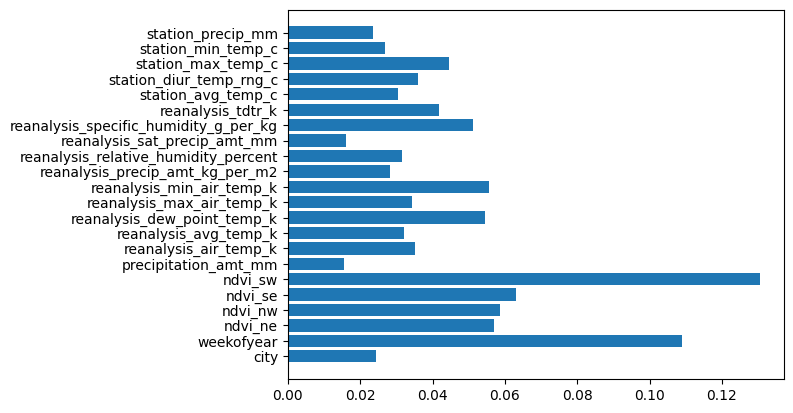

In [54]:
plt.barh(selected_features[:-1],MejorRAndomFOrest.feature_importances_)


RandomForestRegressor(max_depth=29, max_features=0.6, min_samples_leaf=4,
                      n_estimators=193)

In [ ]:
best_random.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 27,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 118,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
yp=best_random.predict(validationRFcv1.drop(['total_cases'],axis=1))
print('R cuadrado: ',best_random.score(validationRFcv1.drop(['total_cases'],axis=1),validationRFcv1['total_cases']))
print('MEA: ',mean_absolute_error(yp,validationRFcv1['total_cases']))

R cuadrado:  0.4005194459795356
MEA:  17.7859064737006


In [59]:
yp=best_random.predict(testsn[selected_features_test])

Parámetros de la mejor soluciñon hasta ahora 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 26,
 'max_features': 0.8,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 242,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:

from pandas.core import base

def evaluate(model, test_features, test_labels):

    predictions = model.predict(test_features)
    R2=model.score(test_features,test_labels)
    mea=mean_absolute_error(predictions,test_labels)
    
    print('Model Performance')
    print('R2:  {:0.4f}.'.format(R2))
    print('MEA: ',mea,'%')
    return mea

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(trainRFcv1.drop(['total_cases'],axis=1), trainRFcv1['total_cases'])
base_accuracy = evaluate(base_model, validationRFcv1.drop(['total_cases'],axis=1).to_numpy(), validationRFcv1['total_cases'].to_numpy())
print(base_accuracy)
#best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, validationRFcv1.drop(['total_cases'],axis=1).to_numpy(), validationRFcv1['total_cases'].to_numpy())
print('Improvement of {:0.2f}%.'.format( 100 * (-random_accuracy + base_accuracy) / base_accuracy))
print('------------------------\n')


Model Performance
R2:  0.2020.
MEA:  18.823569794050343 %
18.823569794050343
Model Performance
R2:  0.2213.
MEA:  18.63091030935557 %
Improvement of 1.02%.
------------------------



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Vemos como el modelo a mejorado sustancialmente. Y vamos a calcular los resultados del test de este modelo.  
La implementación del test sobre los datos de prueba se hace al final del notebook.  

In [ ]:
from joblib import dump
dump(best_random, 'RandomForest16.9')

['RandomForest16.9']

El valor que ha obtenido en drivendata para los datos de test procesados para añadirles la característica del cluster al que pertenece esos datos (Actividad 1) ha obtenido un 26,7452 de resultado. 

A pesar de haber sido el mejor modelo durante la validación vemos como en test su desempeño es bastante peor. Se puede deber al overfitting. 





Vamos a modificar algunos parámetros para ver si mejoramos el resultado 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]
max_features = [0.5, 0.6,0.7]
max_depth = [int(x) for x in np.linspace(2, 35, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]#,False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#pprint(random_grid)

In [ ]:
user=input('Dale a 1 para calcular de nuevo los hiperparámetros, a 0 si quieres cargarlo en caso de tenerlo guardado en drive y a 2 para usar el mejor calculado:  ') 
try:
   int(user) 
except:
  user=666
  
if int(user)==1:

  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  rf = RandomForestRegressor()
  # Random search of parameters, using 3 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=20, n_jobs = -1)
  # Fit the random search model
  rf_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])
  best_random = rf_random.best_estimator_
elif user==0:
  
  best_random = load('/content/drive/MyDrive'+path+'/RandomForestCV42881.joblib')
  best_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])
else:
  best_random=RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      n_estimators=242)
  best_random.fit(X=trainRFcv1.drop(['total_cases'],axis=1), y=trainRFcv1['total_cases'])

Dale a 1 para calcular de nuevo los hiperparámetros, a 0 si quieres cargarlo en caso de tenerlo guardado en drive y a 2 para usar el mejor calculado:  3


In [ ]:
MejorRAndomFOrest2 = best_random
MejorRAndomFOrest2

RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      n_estimators=242)

In [ ]:

from pandas.core import base

def evaluate(model, test_features, test_labels):

    predictions = model.predict(test_features)
    R2=model.score(test_features,test_labels)
    mea=mean_absolute_error(predictions,test_labels)
    
    print('Model Performance')
    print('R2:  {:0.4f}.'.format(R2))
    print('MEA: ',mea,'%')
    return mea

base_model = RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      n_estimators=242)
base_model.fit(trainRFcv1.drop(['total_cases'],axis=1), trainRFcv1['total_cases'])
base_accuracy = evaluate(base_model, validationRFcv1.drop(['total_cases'],axis=1).to_numpy(), validationRFcv1['total_cases'].to_numpy())
print(base_accuracy)
#best_random = rf_random.best_estimator_
random_accuracy = evaluate(MejorRAndomFOrest2, validationRFcv1.drop(['total_cases'],axis=1).to_numpy(), validationRFcv1['total_cases'].to_numpy())
print('Improvement of {:0.2f}%.'.format( 100 * (-random_accuracy + base_accuracy) / base_accuracy))
print('------------------------\n')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Model Performance
R2:  0.2266.
MEA:  18.562871835808554 %
18.562871835808554
Model Performance
R2:  0.2046.
MEA:  18.57090362940638 %
Improvement of -0.04%.
------------------------



Aunque el modelo es ligeramente peor* con los datos de test y validación, el score ha mejorado obteniendo un valor de 26.3293.   
Vemos como la modificación de los parámetros  

  *n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]*
Aumentamos el número mínimo de estimadores  

*max_features = [0.5, 0.6,0.7]*
definimos que solo pueda emplear el 50% 60% y 70% de las características
*max_depth = [int(x) for x in np.linspace(2, 35, num = 30)]* 
Reducimos la profundidad para evitar el overfitting del data set de train. 
  

Ha tenido el resultado esperado. 
La perdida de especificidad del modelo para el conjuunto de datos del test ha conseguido un mejor rendimiento. 

*En ocasiones varia ligeramente el modelo, no he conseguido determinar por que ya que creo que establezco las semillas correctamente.El modelo que se entreno y valido era 0.21% peor en MEA *texto en cursiva*

## KNN Algoritmo

In [ ]:
from sklearn import neighbors

Para ver el comportamineto de los datos escalados vamos a emplear un algoritmo basado en distancias como es el KNN. Vamos a comenzar usando todas las características calculadas en la Actividad 1 pero normalizadas.  

Vamos a aplicar la implementación de cross-validation vista en clase 

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
trainsn_e.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'kmeans2ciudades',
       'dendograma', 'total_cases'],
      dtype='object')

Se van a ver los resultados para tres conjuntos de datos diferentes, el primero contiene los datos originales de la actividad 1 sin la adición de los clusteres formados por kmeans, el segundo es un subconjunto y el tercero es como el primero incluyendo estas features. 

Min Value uniform : 17.92353358009871 (16)
Min Value distance : 17.869124653248587 (26)


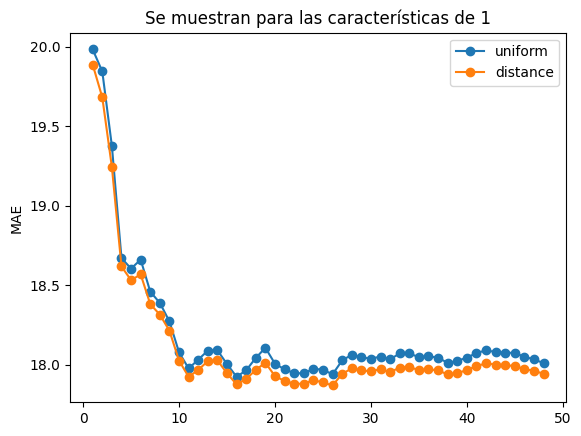

Min Value uniform : 18.26352103804485 (44)
Min Value distance : 18.235737455578324 (44)


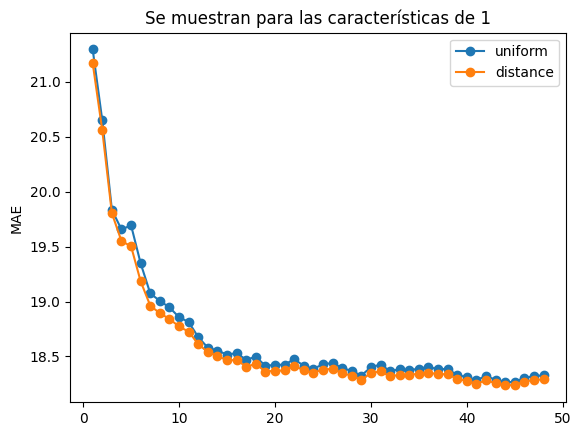

Min Value uniform : 18.03277234504913 (23)
Min Value distance : 17.96062627572832 (23)


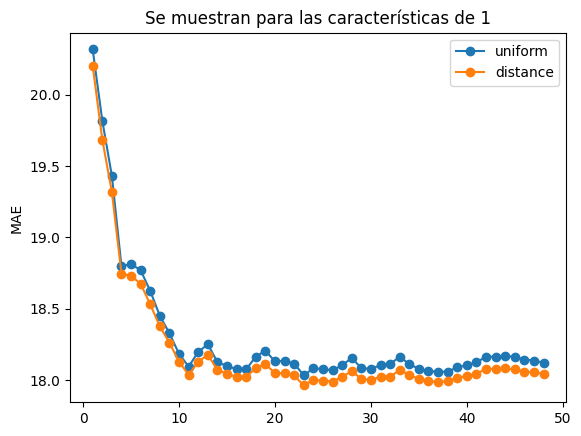

In [ ]:

cv = KFold(n_splits = 30, shuffle = True, random_state=42) #
# se podría utilizar https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 
iter=[selected_features,selected_features2,selected_features3]#
i=0
for features in iter:
  
  train=trainsn_e[features]
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(2,50):
        fold_accuracy = []
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
        # verificar cada uno de los modelos con validación cruzada.
        for train_fold, test_fold in cv.split(train):
            # División train test aleatoria
            f_train = train.loc[train_fold]
            f_test = train.loc[test_fold]
            # entrenamiento y ejecución del modelo
            knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                                y = f_train['total_cases'])
            y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
            # evaluación del modelo
            mae = mean_absolute_error(f_test['total_cases'], y_pred)
            fold_accuracy.append(mae)
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

    
    plt.plot(range(1,len(total_scores)+1), total_scores, 
              marker='o', label=weights)
    print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
    plt.ylabel('MAE')
      
  plt.title('Se muestran para las características de '+ str(i))   
  i=i+1 
  plt.legend()
  plt.show()
  

Vemos como para cada subconjunto de características obtenemos un MAE similar.  
El mejor es el primero, aunque los resultados de Test más optimos han sido con el tercero Esto se debe a la variable que se ha añadido. En la tabla resumen se incluye el valor de este experimento con el data set de train MAE:25.9880 para un valor de MAE con los datos de validación de 18.54. 



In [ ]:
from sklearn.model_selection import train_test_split
trainKNN, validationKNN = train_test_split(trainsn_e[selected_features3], test_size=0.3, random_state=10)
trainKNN.reset_index(inplace = True,drop=True)
validationKNN.reset_index(inplace = True,drop=True)

Dividimos el data set en train y validation y pasamos a entrenar el modelo. 

In [ ]:
n_neighbors = 23
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = trainKNN.drop(['total_cases'], axis=1), y = trainKNN['total_cases'])
y_predknnval = knn.predict(X = validationKNN.drop(['total_cases'], axis = 1))
mae = mean_absolute_error(validationKNN['total_cases'], y_predknnval)
print ('MAE', mae)


MAE 18.76571091616651


Obtenemos un MAE de 18.765, un buen resultado. Veremos como se comporta con los datos de train. 

# Generación del Resultado Final

En este apartado recojo los modelos calculados y evaluados para calcular su predicción sobre los datos de test correspondientes. Puede dar error ya que no se considera parte del flow del trabajo y ha sido manual. Los resultados estan al final resumidos en una tabla. 

Generamos el fichero de salida segun el Submission format

* Realizamos la predicción sobre el test

In [ ]:
y_pred=regresmodel.predict(test_e[selected_features_test])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:

try:
  y_pred=regr.predict(testregr[selected_features_test])
except:
  pass

Caso de Características seleccionadas de práctica 1 

Modelo conseguido con los datos procesados en bruto. Realizado en la primera parte del documento para el algoritmo de regresion y para el primer Random forest

In [ ]:

  passRandomForestAllFeaturesRaw=RandomForestRegressor(bootstrap=False, max_depth=55, max_features='sqrt',
                      min_samples_leaf=2)


Mejor modelo Random Forest con los datos sin escalar obtenidos del proceso. 

In [ ]:
BestModelAllFeatures=RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      n_estimators=242)
trainRFcv1, validationRFcv1
BestModelAllFeatures.fit(trainRFcv1.drop(['total_cases'],axis=1),trainRFcv1['total_cases'])

RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=2,
                      n_estimators=242)

In [ ]:
base_accuracy = evaluate(BestModelAllFeatures, validationRFcv1.drop(['total_cases'],axis=1).to_numpy(), validationRFcv1['total_cases'].to_numpy())

Model Performance
R2:  0.2160.
MEA:  18.65738319653987 %


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
y_pred=BestModelAllFeatures.predict(testsn[selected_features_test2])

Segundo modelo de Random Forest entrenado con cross validation para reducir su overfitting 

In [ ]:
BestModelAllFeatures2=RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=4,
  n_estimators=326)
BestModelAllFeatures2.fit(trainRFcv1.drop(['total_cases'],axis=1),trainRFcv1['total_cases'])
try:
  y_pred=BestModelAllFeatures2.predict(testsn[selected_features_test3])
except:
  pass

In [ ]:
y_pred = knn.predict(X = testsn_e[selected_features_test3])

* Redondeamos el resultado

In [60]:
y_pred=yp

In [61]:
y = y_pred.astype(int) # cast to int
res = np.hstack(y)

In [62]:
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [63]:
# generate output
try:
  test['city']=test['city'].astype('int')
  test['city']=lb.inverse_transform(test['city'])
except:
  pass

output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': y_pred_no_neg})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)

files.download('result.csv')
output.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,14
1,sj,2008,19,16
2,sj,2008,20,22
3,sj,2008,21,24
4,sj,2008,22,24


# Score board

Se ha empleado el usuario de **mrbellolegua** para el test de los resultados. Se han realizado más experimentos que los aqui expuestos.

Resultados experimentos
SIN SELECCIONAR DATOS  
*   Regresion lineal "Crudo" MAR 34.3702
*   RandomForest base line MAR 26.8678
*   BestModelAllFeatures  CVfold tunning tunning MAR 26.7452
*   BestModelAllFeatures2 CVfold tunning tunning MAR 26.3293
*   Knn MAR 25.9980
*   Modelo RandomForest perdido por no usar seed con MAR 25.6851| Es un dolor, pero pongo captura. 


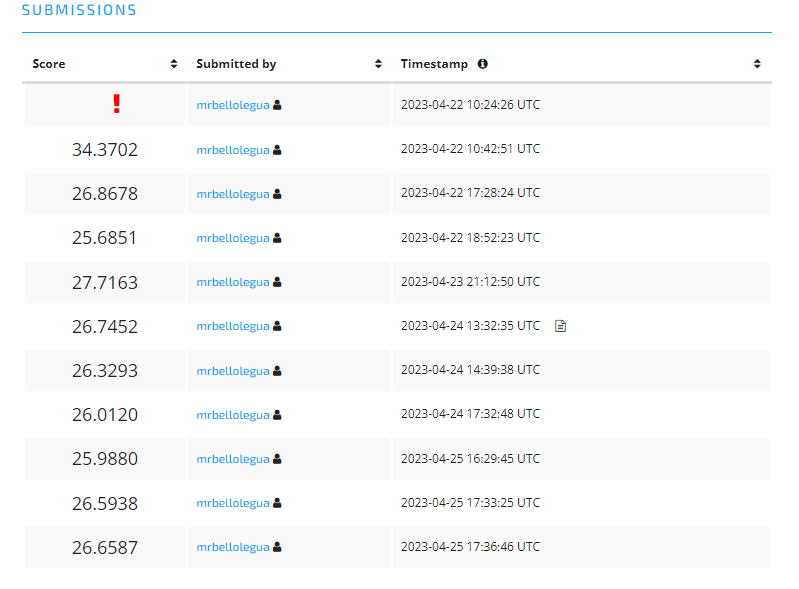








# Conclusiones generales
Tras realizar este trabajo se ha llegado a una serie de conclusiones generales que paso a comentar a continuación: 

La elección correcta del algoritmo a entrenar puede ser importante, si bien el ajuste de sus hiperparámetros lo es más. 

Se ha podido comprobar mediante experimentación que el empleo de datos sin normalizar en algortimos basados en distancias como KNN presenta un rendimiento más pobre frente al empleo de losd datos normalizados. 

La adición de características en algunos casos a llevado consigo una mejoría de los resultados de la predicción, sin embargo el empleo de subconjuntos de datos no han propiciado ningún tipo de mejoría. 

El problema del over fitting esta presente en todos los algoritmos en mayor o menor medida, los resultados de test han llegado a empeorar en modelos de KNN calculados con menores valor de MEA y R2 más altos. Vemos como no existe una relación lineal entre los resultados de validación y los de Train. 

# Comentarios sobre el trabajo 

En el caso de la implementación de Random Forest Regresor se ha optado por un metodo de estimación de parámetros basado en la aleatoriedad que se ha demostrado ineficiente en terminos de tiempo/resultados. Existen distintos metodos de ajuste publicados por internet basados en optimización bayesiana que valdría la pena implementar. No obstante todos ellos van a necesitar de lo mismo, buen dato y tiempo de procesamiento. 
https://newsletter.theaiedge.io/p/deep-dive-tuning-xgboost-hyperparameter?token=eyJ1c2VyX2lkIjoxMjE3MzA5NzcsInBvc3RfaWQiOjExNTUzNzgzMywiaWF0IjoxNjgyMTc1NjY2LCJleHAiOjE2ODQ3Njc2NjYsImlzcyI6InB1Yi0xMjM4MDc0Iiwic3ViIjoicG9zdC1yZWFjdGlvbiJ9.ZkDIiRdVLT2TcP7VCZrAkOJOjxwCuaTXrXThah9ip90&utm_source=substack&utm_medium=email

Al haber trabajado sobre los datos de forma "descuidada" se han podido producir variaciones en los data sets utilizados haciendo que los resultados de los modelos no siempre fuesen los mismos. Esto ha sido un problema a lo largo del trabajo que no se ha resuelto, peros e tendrá en cuenta de cara al futuro. 

El algoritmo de Random Forest Regresor ha dado los mejores resultados, aunque de forma excepcional ya que el modelo calculado se perdio. El mayor número de parámetros no es necesariamente una ventaja siempre y cuando no se disponga de los conocimientos suficientes para tunearlos todos, y posiblemente un data set lo suficientemente grande ya que de lo contrario se deriba en problemas de overfitting como los que se ha tenido. 